# DAG Visualization

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from IPython.display import clear_output

Загрузим несколько примеров ориентированных ациклических графов

In [ ]:
! wget https://github.com/glebelg/DataVisualization-2021/raw/main/2_DAGVisualization/flow-8n.xml
! wget https://github.com/glebelg/DataVisualization-2021/raw/main/2_DAGVisualization/flow-16n.xml
! wget https://github.com/glebelg/DataVisualization-2021/raw/main/2_DAGVisualization/flow-32n.xml

clear_output()

Реализуем основные функции для отрисовкии графа

In [ ]:
def comp(set1, set2):
    set1.sort(reverse=True)
    set2.sort(reverse=True)
    for i in range(min(len(set1), len(set2))):
        if set1[i] != set2[i]:
            return set1[i] < set2[i]
    return len(set1) < len(set2)


def coffman_graham(G):
    names = {n : 1e9 for n in G.nodes}
    roots = list(set(edge[0] for edge in G.edges) - set(edge[1] for edge in G.edges))
 
    for num, r in enumerate(roots):
        names[r] = num
    num = len(roots)

    order = []
    reversed_neighbors = roots
    for _ in range(len(G.nodes)):
        reversed_sets = {}
        for n in reversed_neighbors:
            for reversed_n in list(G.neighbors(n)):
                if reversed_n not in reversed_neighbors:
                    reversed_sets[reversed_n] = list(G.reverse().neighbors(reversed_n))

        least_set = None
        node = None

        for n, reversed_set in reversed_sets.items():
            if least_set is None:
                least_set = [names[v] for v in reversed_set]
                node = n
                continue

            cur_set = [names[v] for v in reversed_set]
            oldLeast = comp(least_set, cur_set)
            least_set = least_set if oldLeast else cur_set
            node = node if oldLeast else n

        if least_set is not None:
            reversed_neighbors.append(node)
            names[node] = num
            num += 1

    return names

In [ ]:
def form_layers(G, names, W=None):
    L = [[]]
    l = 0
    n2l = {}

    for n, k in sorted(names.items(), key=lambda x: x[1], reverse=True):
        if W is not None:
            if len(L[l]) == W:
                L.append([])
                l += 1
            for neighbor in list(G.neighbors(n)):
                if neighbor in L[l]:
                    L.append([])
                    l += 1
                    break
            
            L[l].append(n)
        else:
            n_neighbors = [n2l[neighbor] for neighbor in list(G.neighbors(n)) if neighbor in n2l.keys()]
            l = l if len(n_neighbors) == 0 else max(n_neighbors) + 1
            if l >= len(L):
                L.append([])
            
            L[l].append(n)
            n2l[n] = l

    L.reverse()
    node2layer = {n: i for i, l in enumerate(L) for n in l}

    return L, node2layer

In [ ]:
def add_dummies(G, L, node2layer):
    dummies = 0
    dummy = 0
    edges = list(G.edges)

    for edge in edges:
        if node2layer[edge[1]] - node2layer[edge[0]] > 1:
            G.remove_edge(*edge)
            chain = [edge[0]]
            for l in range(node2layer[edge[0]] + 1, node2layer[edge[1]]):
                G.add_node(f'd{dummy}')
                L[l].append(f'd{dummy}')
                chain.append(f'd{dummy}')
                dummy += 1
            chain.append(edge[1])

            for i in range(len(chain) - 1):
                G.add_edge(chain[i], chain[i+1])
    return G, L

In [ ]:
def get_pos(G, L):
    pos = {}
    for y, layer in enumerate(L):
        for x, n in enumerate(layer):
            if y == 0:
                pos[n] = (0, -y)
                c = 0
            else:
                pos[n] = (c - len(layer) / 2 + 0.5 + x, -y)
    return pos

In [ ]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0] * p2[1] - p2[0] * p1[1])
    return A, B, -C


def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x, y
    else:
        return None


def is_point_on_segment(p, e, pos):
    return p[0] <= max(pos[e[0]][0], pos[e[1]][0]) and \
           p[0] >= min(pos[e[0]][0], pos[e[1]][0]) and \
           p[1] <= max(pos[e[0]][1], pos[e[1]][1]) and \
           p[1] >= min(pos[e[0]][1], pos[e[1]][1])


def count_crossings(G, pos):
    edges = list(G.edges)

    crossings = 0
    for i, e1 in enumerate(edges[:-1]):
        for e2 in edges[i + 1:]:
            e1_line = line(pos[e1[0]], pos[e1[1]])
            e2_line = line(pos[e2[0]], pos[e2[1]])

            p = intersection(e1_line, e2_line)

            if p is not None and is_point_on_segment(p, e1, pos) and \
                                 is_point_on_segment(p, e2, pos) and \
                                 p != pos[e1[0]] and p != pos[e1[1]] and p != pos[e2[0]] and p != pos[e2[1]]:
                crossings += 1

    return crossings


In [ ]:
def optimize_crossings(G, L, pos, iters=5000):
    for _ in range(iters):
        l = np.random.randint(0, len(L))
        if len(L[l]) >= 2:
            n1, n2 = np.random.choice(L[l], 2, replace=False)

            crossings = count_crossings(G, pos)
            pos[n1], pos[n2] = pos[n2], pos[n1]

            cur_crossings = count_crossings(G, pos)

            if cur_crossings > crossings:
                pos[n1], pos[n2] = pos[n2], pos[n1]
    return pos

In [ ]:
def pipeline(G, W=None, iters=5000):
    # пронумеруем вершины графа с помощью алгоритма Коффмана-Грэма
    names = coffman_graham(G)

    # распределим вершины по слоям
    L, node2layer = form_layers(G, names, W=W)

    # добавим dummy-вершины
    G, L = add_dummies(G.copy(), L.copy(), node2layer)

    # рассчитаем координаты
    pos = get_pos(G, L)

    # оптимизируем число пересечений ребер
    pos = optimize_crossings(G, L, pos.copy(), iters)

    return G, pos

Изобразим загруженные графы

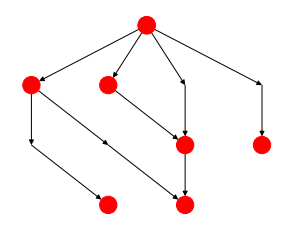

In [ ]:
G = nx.read_graphml('flow-8n.xml')

G, pos = pipeline(G.copy(), W=2)

f = plt.figure(figsize=(5,4))
node_size = [300 if n[0] != 'd' else 0 for n in G.nodes]
nx.draw(G, pos=pos, node_color='red', with_labels=False, node_size=node_size, ax=f.add_subplot(111))
f.savefig("flow-8n-w2.png")

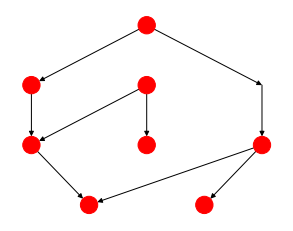

In [ ]:
G = nx.read_graphml('flow-8n.xml')

G, pos = pipeline(G.copy(), W=None)

f = plt.figure(figsize=(5,4))
node_size = [300 if n[0] != 'd' else 0 for n in G.nodes]
nx.draw(G, pos=pos, node_color='red', with_labels=False, node_size=node_size, ax=f.add_subplot(111))
f.savefig("flow-8n.png")

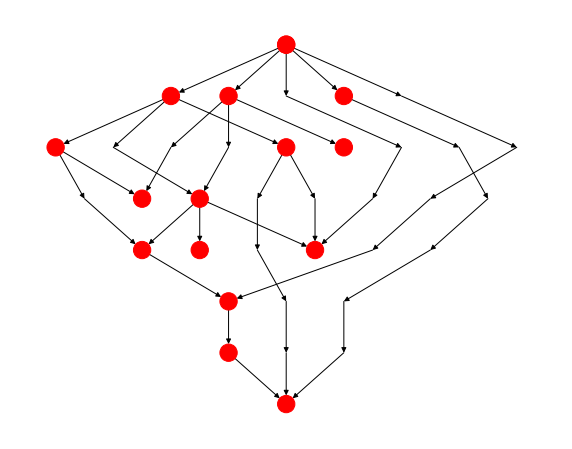

In [ ]:
G = nx.read_graphml('flow-16n.xml')

G, pos = pipeline(G.copy(), W=3)

f = plt.figure(figsize=(10,8))
node_size = [300 if n[0] != 'd' else 0 for n in G.nodes]
nx.draw(G, pos=pos, node_color='red', with_labels=False, node_size=node_size, ax=f.add_subplot(111))
f.savefig("flow-16n-w3.png")

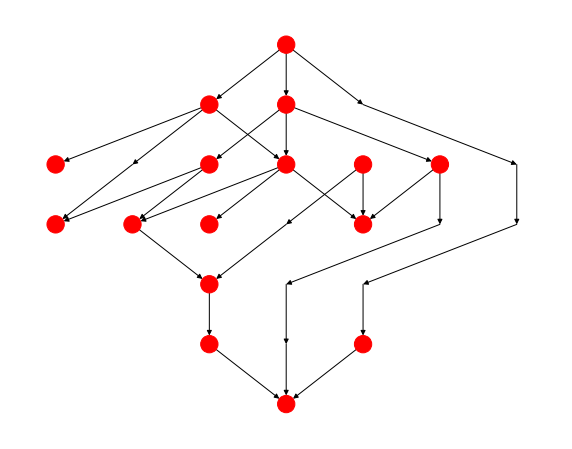

In [ ]:
G = nx.read_graphml('flow-16n.xml')

G, pos = pipeline(G.copy(), W=None)

f = plt.figure(figsize=(10,8))
node_size = [300 if n[0] != 'd' else 0 for n in G.nodes]
nx.draw(G, pos=pos, node_color='red', with_labels=False, node_size=node_size, ax=f.add_subplot(111))
f.savefig("flow-16n.png")

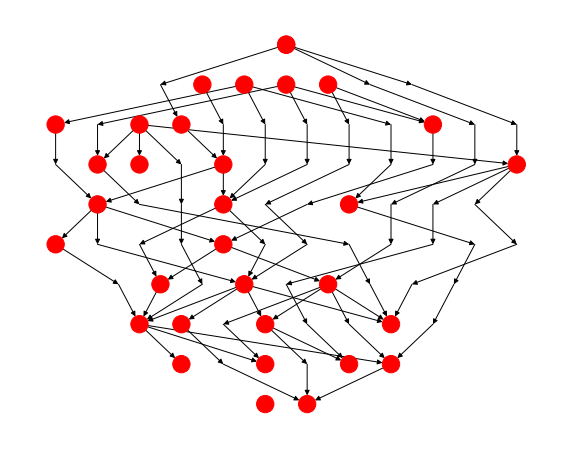

In [ ]:
G = nx.read_graphml('flow-32n.xml')

G, pos = pipeline(G.copy(), W=4, iters=1500)

f = plt.figure(figsize=(10,8))
node_size = [300 if n[0] != 'd' else 0 for n in G.nodes]
nx.draw(G, pos=pos, node_color='red', with_labels=False, node_size=node_size, ax=f.add_subplot(111))
f.savefig("flow-32n-w4.png")

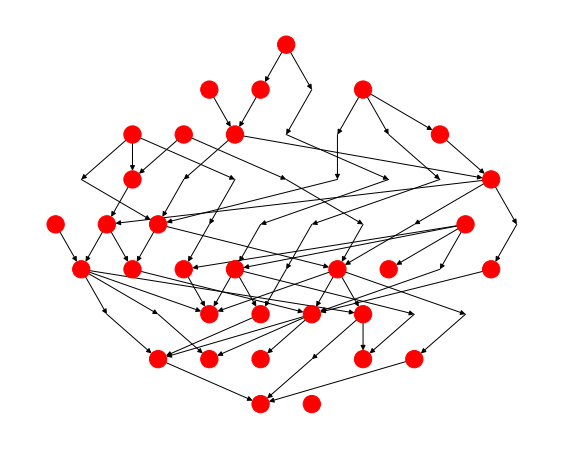

In [ ]:
G = nx.read_graphml('flow-32n.xml')

G, pos = pipeline(G.copy(), W=None, iters=1500)

f = plt.figure(figsize=(10,8))
node_size = [300 if n[0] != 'd' else 0 for n in G.nodes]
nx.draw(G, pos=pos, node_color='red', with_labels=False, node_size=node_size, ax=f.add_subplot(111))
f.savefig("flow-32n.png")